<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
! pip install --upgrade --no-cache-dir gdown --quiet
! pip install np_utils

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

def plot_dist(frame, key):

  ratings_distribution = frame[key].value_counts().sort_index()
  print(ratings_distribution)

  plt.figure(figsize=(8, 6))
  plt.bar(ratings_distribution.index, ratings_distribution.values)
  plt.xlabel(key)
  plt.ylabel('Count')
  plt.title(f'{key} Distribution')
  plt.show()

  ratings_distribution_pct = (frame[key].value_counts(normalize=True) * 100).sort_index()
  print(ratings_distribution_pct)

0      821
1     1549
2     2823
3     4908
4    12540
Name: Rating, dtype: int64


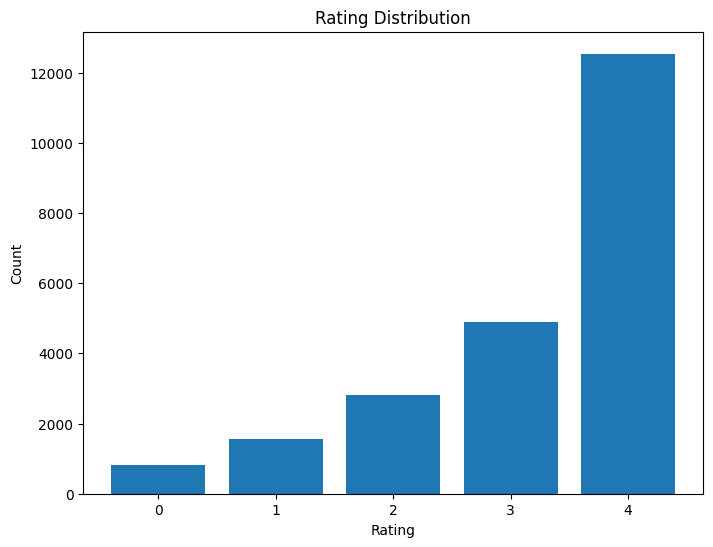

0     3.626165
1     6.841571
2    12.468531
3    21.677488
4    55.386246
Name: Rating, dtype: float64


In [7]:
plot_dist(df_reviews, "Rating")

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

reviews = df_reviews['Review Text'].values
reviews

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       "This fit well, but the top was very see through. this never would have worked for me. i

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(reviews)

22641

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus

def get_list(series):
    reviews_list = series.tolist()
    reviews_list = [str(text) if not pd.isnull(text) else "" for text in reviews_list]
    return reviews_list

def concat_all(series):
  reviews_list = get_list(series)
  all_reviews_one_string = ' '.join(reviews_list)
  return all_reviews_one_string

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(concat_all(reviews))

7011643

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

all_reviews_one_string = concat_all(reviews)
tokens = text_to_word_sequence(all_reviews_one_string)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

reviews_list = get_list(reviews)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews_list)
sequences = tokenizer.texts_to_sequences(reviews_list)

In [16]:
sequences[0]

[253, 532, 917, 3, 662, 3, 68]

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tokenizer.word_index
len(word_index)

14847

In [18]:
# Alumno: Determinar cual es la oración más larga

def longest_seq(seqs):
  sentence_lengths = [len(sequence) for sequence in seqs]
  index_of_longest_sentence = sentence_lengths.index(max(sentence_lengths))
  longest_sentence = seqs[index_of_longest_sentence]

  print(len(seqs[index_of_longest_sentence]))
  return reviews_list[index_of_longest_sentence]

lgst_seq = longest_seq(sequences)

115


In [19]:
lgst_seq

"I love maeve tops. i love the material and feel of this brand. when i saw the new tops that came out i ran to my local store to try one on. i'm usually a large in a top, once in a while an xl. they only had a large to try so i tried it in the black motif.\ni could barely get the top on. it looked like i was missing 1/2 of the top. i doubled checked the size and it was a large.\nit's a shame, the top is really cute. if you are the least bit broad or busty, go up a size or two. if you are usually a"

In [20]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

max_sequence_length = max([len(sequence) for sequence in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [21]:
# Alumno: Observar las dimensiones de la variable input
padded_sequences.shape

(22641, 115)

In [22]:
X = padded_sequences

In [23]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

import numpy as np
from keras.utils import to_categorical

ratings = df_reviews['Rating'].dropna()

# Transforma las calificaciones a representación One-Hot Encoding
y = to_categorical(ratings)

y.shape

(22641, 5)

In [24]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Alumno: determinar la dimensiones de entrada y salida
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]
print(input_shape)
print(output_shape)

115
5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [26]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.

En el primer intento de entrenamiento se utilizaron los datos sin balancear como referencia inicial. Este paso proporciona una base para evaluar la mejora que se espera al utilizar datos balanceados en los experimentos posteriores.

Además, se ha preparado una arquitectura básica de modelo que consta de capas de Embeddings, Dropout, una capa LSTM y una capa fully connected. Este modelo servirá como punto de partida para ;ps experimentos, y a partir de aquí, se realizaran modificaciones y ajustes para lograr mejores resultados.

In [27]:
! pip install -U imbalanced-learn


In [28]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=42)

# Perform undersampling with the custom strategy on your dataset
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [29]:
# Count the occurrences of each class label
categorical_labels = np.argmax(y_resampled, axis=1)
unique_classes, class_counts = np.unique(categorical_labels, return_counts=True)

# Create a dictionary to display the class distribution
class_distribution = dict(zip(unique_classes, class_counts))

# Print the class distribution
print("Class Distribution (Class: Count)")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class Distribution (Class: Count)
Class 0: 821 samples
Class 1: 821 samples
Class 2: 821 samples
Class 3: 821 samples
Class 4: 821 samples


In [30]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32)

In [31]:
from keras.layers import LSTM, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(embedding_dim=100, lstm_units = 128, dense_units = 64, dropout_rate=0.2):

  model = Sequential()

  model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True))

  model.add(LSTM(units=lstm_units, return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(units=lstm_units))
  model.add(Dropout(dropout_rate))

  model.add(Dense(units=dense_units, activation='relu'))
  model.add(Dropout(dropout_rate))

  num_classes = 5  # Adjust as needed
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = create_model(100, 64, 128, 0.3)

hist = model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=256, validation_split=0.2)

loss, accuracy = model.evaluate(X_test_resampled, y_test_resampled)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/30
11/11 [==============================] - 23s 612ms/step - loss: 1.6096 - accuracy: 0.2029 - val_loss: 1.6098 - val_accuracy: 0.1826
Epoch 2/30
11/11 [==============================] - 7s 617ms/step - loss: 1.6113 - accuracy: 0.1953 - val_loss: 1.6093 - val_accuracy: 0.2192
Epoch 3/30
11/11 [==============================] - 3s 236ms/step - loss: 1.6099 - accuracy: 0.1987 - val_loss: 1.6096 - val_accuracy: 0.1857
Epoch 4/30
11/11 [==============================] - 2s 208ms/step - loss: 1.6105 - accuracy: 0.1903 - val_loss: 1.6095 - val_accuracy: 0.1857
Epoch 5/30
11/11 [==============================] - 2s 143ms/step - loss: 1.6100 - accuracy: 0.1976 - val_loss: 1.6100 - val_accuracy: 0.1963
Epoch 6/30
11/11 [==============================] - 2s 165ms/step - loss: 1.6090 - accuracy: 0.2132 - val_loss: 1.6097 - val_accuracy: 0.2040
Epoch 7/30
11/11 [==============================] - 1s 129ms/step - loss: 1.6085 - accuracy: 0.2040 - val_loss: 1.6090 - val_accuracy: 0.1994
Epoch

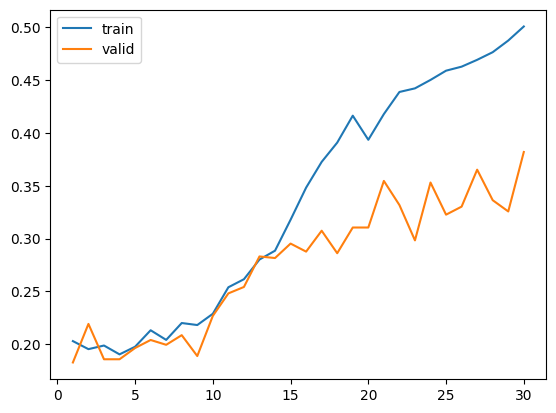

In [32]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [33]:
! pip install gensim

Se utilizo gensim por la facilidad de su uso y para probar otra herramienta ademas de la vista en clase.

In [34]:
import os
import gdown

if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [35]:
import logging
import os
from pathlib import Path

In [36]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [37]:
model_fasttext = FasttextEmbeddings()

In [38]:
print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

nb_words = min(num_words, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [41]:
from gensim.models import Word2Vec

def create_model_emb(lstm_units = 128, dense_units = 64, dropout_rate=0.2):

  # Create a Sequential model
  model = Sequential()

  # Add an Embedding layer
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embed_dim,
                      input_length=max_sequence_length,
                      weights=[embedding_matrix],
                      trainable=False))

  # Add multiple LSTM layers with dropout
  model.add(LSTM(units=lstm_units, return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(units=lstm_units))
  model.add(Dropout(dropout_rate))

  model.add(Dense(units=dense_units, activation='relu'))
  model.add(Dropout(dropout_rate))

  # Add an output layer for classification (e.g., binary or multi-class)
  num_classes = 5  # Adjust as needed
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model_emb = create_model_emb(64, 128, 0.3)

hist_emb = model_emb.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=256, validation_split=0.2)

loss, accuracy = model_emb.evaluate(X_test_resampled, y_test_resampled)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/30
11/11 [==============================] - 5s 141ms/step - loss: 1.6098 - accuracy: 0.1892 - val_loss: 1.6110 - val_accuracy: 0.1918
Epoch 2/30
11/11 [==============================] - 0s 24ms/step - loss: 1.6047 - accuracy: 0.2037 - val_loss: 1.6141 - val_accuracy: 0.2116
Epoch 3/30
11/11 [==============================] - 0s 20ms/step - loss: 1.6017 - accuracy: 0.2284 - val_loss: 1.6108 - val_accuracy: 0.2177
Epoch 4/30
11/11 [==============================] - 0s 24ms/step - loss: 1.6021 - accuracy: 0.2231 - val_loss: 1.6111 - val_accuracy: 0.2283
Epoch 5/30
11/11 [==============================] - 0s 24ms/step - loss: 1.6011 - accuracy: 0.2345 - val_loss: 1.6109 - val_accuracy: 0.2070
Epoch 6/30
11/11 [==============================] - 0s 21ms/step - loss: 1.6017 - accuracy: 0.2257 - val_loss: 1.6090 - val_accuracy: 0.2116
Epoch 7/30
11/11 [==============================] - 0s 20ms/step - loss: 1.6009 - accuracy: 0.2261 - val_loss: 1.6096 - val_accuracy: 0.2222
Epoch 8/30
1

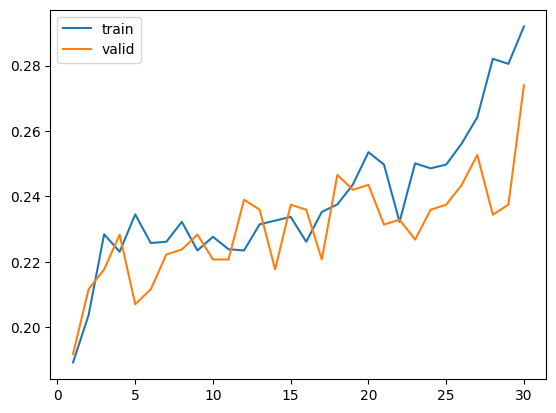

In [42]:
epoch_count = range(1, len(hist_emb.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist_emb.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist_emb.history['val_accuracy'], label='valid')
plt.show()

Este resultado parece ser negativo, ya que con embeddings pre-entrenados no se ha logrado mejorar la precisión ni en el conjunto de entrenamiento ni en el de validación.

La mala performance podría deberse a una limitación que discutimos en clase: los embeddings pre-entrenados pueden tener dificultades para capturar de manera precisa la información relativa a los adjetivos, ya que su contexto puede hacer que estos términos sean muy similares en la representación vectorial.